# Dummy решение задачи "Рекламная кампания"

In [ ]:
# Import libraries 
import pandas as pd
import numpy as np
import time
import gc
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

### 1. Считаем данные и посмотрим на них

In [ ]:
# Read data
data = pd.read_csv('./marketing_campaign_train.csv').drop("Unnamed: 0", axis=1)
display(data.head(3))
display('Всего {} элементов с {} признаками'.format(data.shape[0], data.shape[1]))

,возраст,профессия,семейное_положение,образование,кредит_дефолт,жилищный_кредит,кредит,взаимодействие,контакт_месяц,контакт_день_недели,контакт_количество,контакт_период,контакт_прошлый_количество,контакт_прошлый_исход,контакт_исход,Id
0,33,администриратор,не женат/не замужем,специальное,0.0,0.0,0.0,мобильный,5,пн,1,999,1,0,1,0
1,33,техник/механик,не женат/не замужем,специальное,0.0,1.0,0.0,мобильный,8,ср,1,999,0,-,0,1
2,30,администриратор,не женат/не замужем,высшее,0.0,1.0,0.0,мобильный,5,пн,1,999,0,-,0,2


'Всего 31188 элементов с 16 признаками'

### 2. Анализ категориальных признаков

Посмотрим на то, как связаны открытие/не открытие счета (целевая переменная) и значения каждого из категориальных признаков:

In [ ]:
# Build a function to show categorical values disribution
def plot_bar(column):
    # temp df 
    temp_1 = pd.DataFrame()
    # count categorical values
    temp_1['Счет не открыт'] = data[data['контакт_исход'] == 0][column].value_counts()
    temp_1['Счет открыт'] = data[data['контакт_исход'] == 1][column].value_counts()
    temp_1.plot(kind='bar')
    plt.xlabel(column)
    plt.ylabel('Количество клиентов')
    plt.title('Распределение признака \"{}\" и открытия счета'.format(column))
    plt.show();

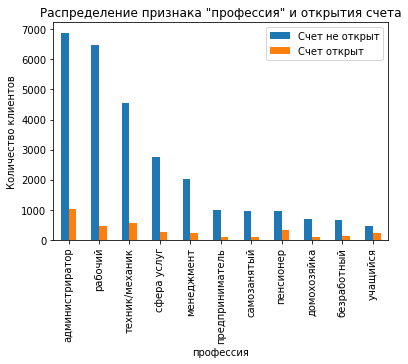

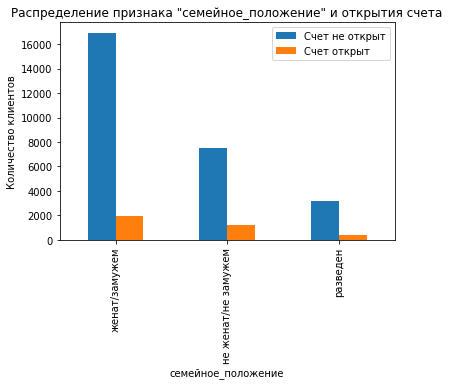

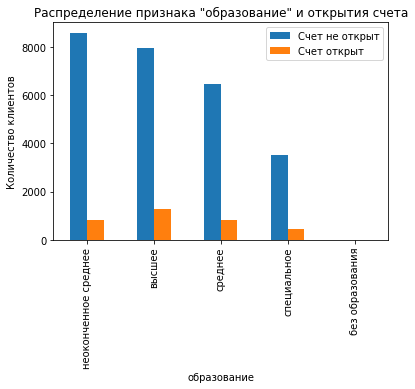

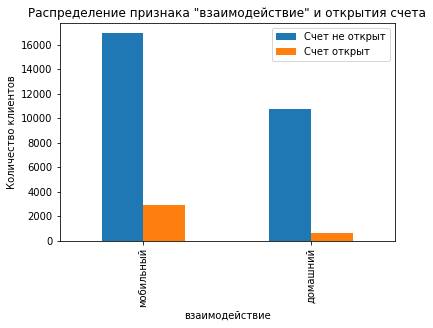

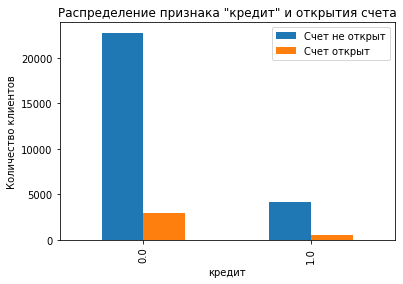

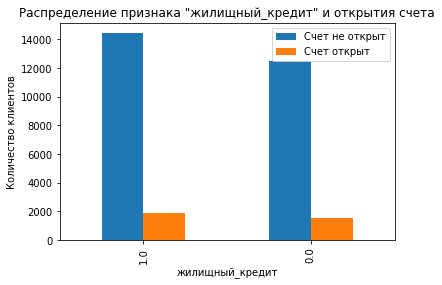

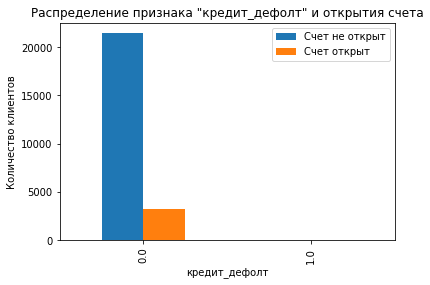

(None, None, None, None, None, None, None)

In [ ]:
plot_bar('профессия'), plot_bar('семейное_положение'), plot_bar('образование'), \
plot_bar('взаимодействие'), plot_bar('кредит'), plot_bar('жилищный_кредит'), plot_bar('кредит_дефолт')

**Какие можно сделать выводы из распределений:**
1. Администраторы и технические спеыиалисты соглашались на открытие счета чаще остальных
2. Хотя в абсолютных величинах женатые открывали счет чаще, в относительных величинах не женатые делали это чаще.
3. Чаще открывают счет клиенты, с которыми велась коммуникация по мобильному телефону.

### 3. Анализ численных признаков

Построим матрицу корреляций численных признаков и ответа:

In [ ]:
# Build correlation matrix
corr = data.drop("Id", axis=1).corr()
corr.style.background_gradient(cmap='PuBu')

,возраст,кредит_дефолт,жилищный_кредит,кредит,контакт_месяц,контакт_количество,контакт_период,контакт_прошлый_количество,контакт_исход
возраст,1.000000,0.000309,-0.004740,-0.008550,0.078447,0.000829,-0.040164,0.027305,0.031529
кредит_дефолт,0.000309,1.000000,-0.009913,-0.003911,0.011800,-0.003432,0.001974,0.004963,-0.003484
жилищный_кредит,-0.004740,-0.009913,1.000000,0.048578,0.031803,-0.012004,-0.008245,0.019397,0.008597
кредит,-0.008550,-0.003911,0.048578,1.000000,-0.005558,0.001094,0.004092,-0.006316,-0.007051
контакт_месяц,0.078447,0.011800,0.031803,-0.005558,1.000000,-0.030330,-0.078548,0.062010,0.041201
контакт_количество,0.000829,-0.003432,-0.012004,0.001094,-0.030330,1.000000,0.051538,-0.076623,-0.064837
контакт_период,-0.040164,0.001974,-0.008245,0.004092,-0.078548,0.051538,1.000000,-0.598104,-0.327004
контакт_прошлый_количество,0.027305,0.004963,0.019397,-0.006316,0.062010,-0.076623,-0.598104,1.000000,0.233274
контакт_исход,0.031529,-0.003484,0.008597,-0.007051,0.041201,-0.064837,-0.327004,0.233274,1.000000


### 4. Предобработка данных

В наших данных встречаются пропуски. Однако количество строк с пропусками не слишком велико, для простоты давайте просто выкинем все строки с пропусками из данных.

In [ ]:
data = data.dropna()

Далее нужно все столбцы с категориальным типом данных привести в числовые. Воспользуемся методом get_dummies() библиотеки pandas, чтобы бинаризовать все категориальные признаки:

In [ ]:
categorical_columns = ["профессия", "семейное_положение", "образование", "взаимодействие", 
                       "кредит", 'контакт_день_недели', "контакт_прошлый_исход"]

In [ ]:
data_dummy = pd.get_dummies(data, columns=categorical_columns)

In [ ]:
data_dummy.head()

,возраст,кредит_дефолт,жилищный_кредит,контакт_месяц,контакт_количество,контакт_период,контакт_прошлый_количество,контакт_исход,Id,профессия_администриратор,профессия_безработный,профессия_домохозяйка,профессия_менеджмент,профессия_пенсионер,профессия_предприниматель,профессия_рабочий,профессия_самозанятый,профессия_сфера услуг,профессия_техник/механик,профессия_учащийся,семейное_положение_женат/замужем,семейное_положение_не женат/не замужем,семейное_положение_разведен,образование_без образования,образование_высшее,образование_неоконченное среднее,образование_специальное,образование_среднее,взаимодействие_домашний,взаимодействие_мобильный,кредит_0.0,кредит_1.0,контакт_день_недели_вт,контакт_день_недели_пн,контакт_день_недели_пт,контакт_день_недели_ср,контакт_день_недели_чт,контакт_прошлый_исход_-,контакт_прошлый_исход_0,контакт_прошлый_исход_1
0,33,0.0,0.0,5,1,999,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0
1,33,0.0,1.0,8,1,999,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0
2,30,0.0,1.0,5,1,999,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0
3,31,0.0,1.0,5,2,999,0,0,3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0
4,31,0.0,1.0,5,1,999,0,0,4,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,1,0,0


Теперь у нас в датасете 39 признаков.

Отделим целевую переменную от данных:

In [ ]:
X, y = data_dummy.drop(["контакт_исход"], axis=1), data_dummy["контакт_исход"]

### 5. Обучение модели

Давайте запустим кросс-валидацию на 5 фолдах с моделью RandomForest и посмотрим, какие получаются величины метрики F1%

In [ ]:
rf = RandomForestClassifier(n_estimators=100, max_depth=15)
cross_val_score(rf, X, list(y), scoring="f1", cv=5)

array([0.24896266, 0.35802469, 0.30670103, 0.33165829, 0.37252619])

Довольно неплохо! Теперь обучим Random Forest с этими же параметрами на всем тренировочном датасете, чтобы потом использовать его на тестовом.

In [ ]:
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### 6. Тест на тестовом датасете

Считаем тестовый датасет:

In [ ]:
data_test = pd.read_csv('./marketing_campaign_test.csv').drop("Unnamed: 0", axis=1)

Проверим, в каких колонках тестовой части есть пропуски. 

In [ ]:
data_test.isna().any()

возраст                       False
профессия                      True
семейное_положение             True
образование                    True
кредит_дефолт                  True
жилищный_кредит                True
кредит                         True
взаимодействие                False
контакт_месяц                 False
контакт_день_недели           False
контакт_количество            False
контакт_период                False
контакт_прошлый_количество    False
контакт_прошлый_исход         False
dtype: bool

Здесь мы уже не можем просто выкинуть строчки с пропусками -- нам нужно дать 

---

ответ на все объекты тестовой выборки. 
Поэтому заменим пропуски на самые часто встречающиеся значения соответствущих колонок (то, какое значение встречается чаще всего, можно понять из графиков, которые мы построили в самом начале ноутбука)

In [ ]:
data_test["профессия"] = data_test["профессия"].fillna("администратор")
data_test["семейное_положение"] = data_test["семейное_положение"].fillna("женат/замужем")
data_test["образование"] = data_test["образование"].fillna("неоконченное среднее")
data_test["кредит_дефолт"] = data_test["кредит_дефолт"].fillna(0.0)
data_test["жилищный_кредит"] = data_test["жилищный_кредит"].fillna(0.0)
data_test["кредит"] = data_test["кредит"].fillna(0.0)

Отлично. Теперь также используем get_dummies(), чтобы превратить категориальные признаки в числовые.

In [ ]:
data_test_dummy = pd.get_dummies(data_test, columns=categorical_columns)

Ура! Теперь мы можем предсказывать ответы к тестовым данным, используя ранее обученную модель RandomForest'а.

In [ ]:
y_pred = rf.predict(data_test_dummy)

Посчитаем F1-score для наших предсказаний. Для этого считаем правильные ответы на тестовуб выборку из файла:

In [ ]:
y_true = pd.read_csv("marketing_test_ans.csv")
y_true = list(y_true["Out"])

In [ ]:
f1_score(y_pred, y_true)

0.3002056202878684

Довольно неплохо для такого простого решения!

### 7. Идеи для улучшения:

    -- не выкидывать строки с пропусками из тренировочной части датасета, а заполнять пропуски. Можно заполнять пропуски не просто самым часто встречабщимся значением, а с помощью KNN
    -- попробовать другие модели: LogReg, sklearn GradientBoosting, LightGBM, etc. 
    -- подобрать параметры модели
    -- более умная предобработка признаков, добавление новых признаков